In [2]:
'''
Surface Defect Detection using Convolutional AutoEncoder
'''
import torch
import torchvision
import torch.nn as nn
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import pathlib
import os
from tqdm import tqdm
import torch.nn.functional as F
from torchinfo import summary

In [3]:

'''
Train/Test Data Preparation
'''
# normal dataset path
TRAIN_DATASET_PATH = pathlib.Path(os.path.dirname(os.path.realpath('__file__'))).parent.parent / "dataset" / "SDD" / "luxteel" / "ae_dataset" / "train"
TEST_DATASET_PATH = pathlib.Path(os.path.dirname(os.path.realpath('__file__'))).parent.parent / "dataset" / "SDD" / "luxteel" / "ae_dataset" / "test"

# set dataset & dataloader
DATA_BATCH_SIZE = 10
train_dataset = ImageFolder(TRAIN_DATASET_PATH, transform=transforms.ToTensor())
train_dataloader = DataLoader(dataset=train_dataset, batch_size=DATA_BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

test_dataset = ImageFolder(TEST_DATASET_PATH, transform=transforms.ToTensor())
test_dataloader = DataLoader(dataset=test_dataset, batch_size=DATA_BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

# show torch version
print(torch.__version__)

# calculate mean and std for normalization (not required)
_sum_channels = 0
_squared_sum_channels = 0
_total_batches = 0

for data, _ in tqdm(train_dataloader):
    _sum_channels += torch.mean(data, dim=[0,2,3]) # calc mean for each channels (dim=Batch, Channel, Height, Width)
    _squared_sum_channels += torch.mean(data**2, dim=[0,2,3])
    _total_batches += 1

mean = _sum_channels / _total_batches
std = (_squared_sum_channels / _squared_sum_channels - mean ** 2) ** 0.5
print(_sum_channels, _squared_sum_channels, _total_batches)
print(f"Train Dataset : (Mean:{mean}), (Std:{std})")


# device selection function (GPU, CPU, MPS for MacOS)
def get_device_use():
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return torch.device('cpu')
device = get_device_use()
print(f"Selected Device : {device}")

# transfer data into the selected device
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dataloader, device) -> None:
        self.__dataloader = dataloader
        self.__device = device
        
    def __iter__(self):
        for b in self.__dataloader:
            yield to_device(b, self.__device)
            
    def __len__(self):
        return len(self.__dataloader)

# data loader into the device    
train_dataloader = DeviceDataLoader(train_dataloader, device)
test_dataloader = DeviceDataLoader(test_dataloader, device)


2.2.0+cu118


  0%|          | 0/51 [00:00<?, ?it/s]

100%|██████████| 51/51 [00:05<00:00,  9.97it/s]

tensor([15.0500, 15.0500, 15.0500]) tensor([4.7530, 4.7530, 4.7530]) 51
Train Dataset : (Mean:tensor([0.2951, 0.2951, 0.2951])), (Std:tensor([0.9555, 0.9555, 0.9555]))
Selected Device : cuda


In [31]:
'''
Convolutional Auto Encoder
'''

# hyper parameters
LEARNING_RATE = 0.001

class ConvAutoencoder(nn.Module):
    def __init__(self, channels):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.conv_layer_1 = nn.Sequential( # 3 to 128
            nn.Conv2d(in_channels=channels, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2))
        )
        
        self.conv_layer_2 = nn.Sequential( # 128 to 64
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2))
        )
        
        self.conv_layer_3 = nn.Sequential( # 64 to 32
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2))
        )
        
        self.conv_layer_4 = nn.Sequential( # 32 to 16
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2))
        )
        
        # Decoder
        self.trans_conv_layer_0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=2, stride=2, padding=0),
            nn.ReLU()
        )
        
        self.trans_conv_layer_1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=2, stride=2, padding=0),
            nn.ReLU()
        )
        
        self.trans_conv_layer_2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=2, stride=2, padding=0),
            nn.ReLU()
        )
        
        self.trans_conv_layer_3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=channels, kernel_size=2, stride=2, padding=0),
            nn.ReLU()
        )
        
    
    def forward(self, image):
        output = self.conv_layer_1(image)
        output = self.conv_layer_2(output)
        output = self.conv_layer_3(output)
        output = self.conv_layer_4(output)
        
        output = self.trans_conv_layer_0(output)
        output = self.trans_conv_layer_1(output)
        output = self.trans_conv_layer_2(output)
        output = self.trans_conv_layer_3(output)
        
        return output
    

# create model instance on device(GPU)
model = ConvAutoencoder(channels=3).to(device)
#criterion = nn.MSELoss()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# show model summary
summary(model, input_size=(3, 640, 400)) # channel, height, width






Layer (type:depth-idx)                   Output Shape              Param #
ConvAutoencoder                          [3, 640, 400]             --
├─Sequential: 1-1                        [128, 320, 200]           --
│    └─Conv2d: 2-1                       [128, 640, 400]           3,584
│    └─ReLU: 2-2                         [128, 640, 400]           --
│    └─MaxPool2d: 2-3                    [128, 320, 200]           --
├─Sequential: 1-2                        [64, 160, 100]            --
│    └─Conv2d: 2-4                       [64, 320, 200]            73,792
│    └─ReLU: 2-5                         [64, 320, 200]            --
│    └─MaxPool2d: 2-6                    [64, 160, 100]            --
├─Sequential: 1-3                        [32, 80, 50]              --
│    └─Conv2d: 2-7                       [32, 160, 100]            18,464
│    └─ReLU: 2-8                         [32, 160, 100]            --
│    └─MaxPool2d: 2-9                    [32, 80, 50]              --
├─Se

In [32]:
'''
Model Training
'''
steps = 0
EPOCH = 20
BATCH_SIZE = 10

total_steps = len(train_dataloader)
print(f"Total Steps : {total_steps}")

train_losses = []

# learning for every epoch
for epoch in range(EPOCH):
    running_loss = 0
    
    # learning for every batch cycle
    for i, (x_batch, _) in enumerate(train_dataloader):
        steps += 1
        
        outputs = model(x_batch)
        loss = criterion(outputs, x_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()*x_batch.shape[0]
        
        if steps % total_steps == 0:
            model.eval()
            print(f"Epoch : {epoch+1}/{EPOCH}, Training loss: {running_loss/total_steps}")
            train_losses.append(running_loss/total_steps)
            
            steps = 0
            running_loss = 0
            model.train()

# save model            
torch.save(model.state_dict(), './sae_sdd.pth', pickle_protocol=4)

Total Steps : 51
Epoch : 1/20, Training loss: 10.598646682851454
Epoch : 2/20, Training loss: 6.033300675597846
Epoch : 3/20, Training loss: 6.023033050929799
Epoch : 4/20, Training loss: 6.01450055253272
Epoch : 5/20, Training loss: 6.013671638918858
Epoch : 6/20, Training loss: 6.008880512387145
Epoch : 7/20, Training loss: 6.008635420425265
Epoch : 8/20, Training loss: 6.013986935802534
Epoch : 9/20, Training loss: 6.009002222734339
Epoch : 10/20, Training loss: 6.008719474661584
Epoch : 11/20, Training loss: 6.009698510169983
Epoch : 12/20, Training loss: 6.007646065132291
Epoch : 13/20, Training loss: 6.008101538115857
Epoch : 14/20, Training loss: 6.005554503085566
Epoch : 15/20, Training loss: 6.011252227951498
Epoch : 16/20, Training loss: 6.010379954880359
Epoch : 17/20, Training loss: 6.009333063574398
Epoch : 18/20, Training loss: 6.012841276094025
Epoch : 19/20, Training loss: 6.009074087236442
Epoch : 20/20, Training loss: 6.011270939135084


cuda


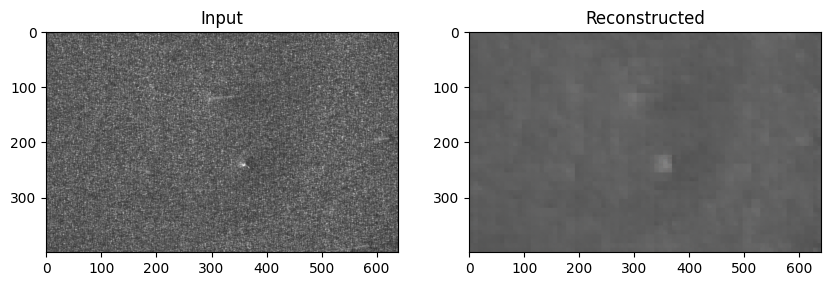

Reconstruction Error : 0.007818122394382954


In [35]:
'''
Use saved model
'''
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
import random

# check device available
def get_device_use():
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return torch.device('cpu')
device = get_device_use()
print(device)

# model load
sdd_model = to_device(ConvAutoencoder(3), device)
sdd_model.load_state_dict(torch.load('./sae_sdd.pth'))
sdd_model.eval()

# ready input image
image = Image.open(TEST_DATASET_PATH/"defect"/"0_12.png")
#image = Image.open(TEST_DATASET_PATH/"normal"/"1_22.png")
preprocess = transforms.Compose([
    transforms.ToTensor(),
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)

# model & input image load to device
input_batch = input_batch.to(device)
# sdd_model.to(device)

with torch.no_grad():
    output = sdd_model(input_batch)
    
output_tensor = output.cpu().squeeze(0)
output_image = transforms.ToPILImage()(output_tensor)

# show image
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Input')

plt.subplot(1, 2, 2)
plt.imshow(output_image)
plt.title('Reconstructed')

plt.show()

# reconstruction error
loss = nn.MSELoss()
reconstruction_loss = loss.forward(input=output_tensor, target=input_tensor)
print(f"Reconstruction Error : {reconstruction_loss}")



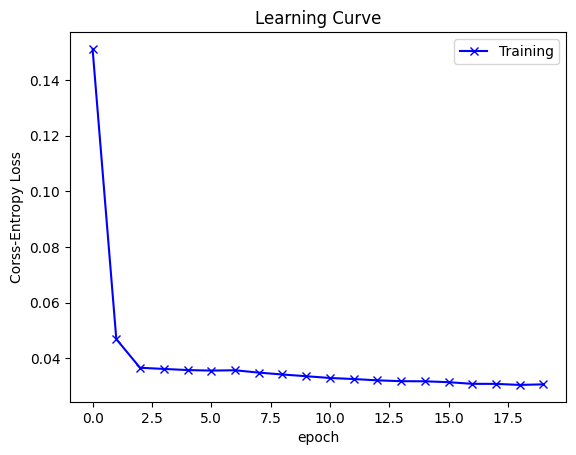

In [23]:
'''
Learning Curve Plot
'''
import matplotlib.pyplot as plt

plt.plot(train_losses, '-bx')
plt.xlabel('epoch')
plt.ylabel('Corss-Entropy Loss')
plt.legend(['Training'])
plt.title('Learning Curve')
plt.show()

RuntimeError: a Tensor with 256000 elements cannot be converted to Scalar

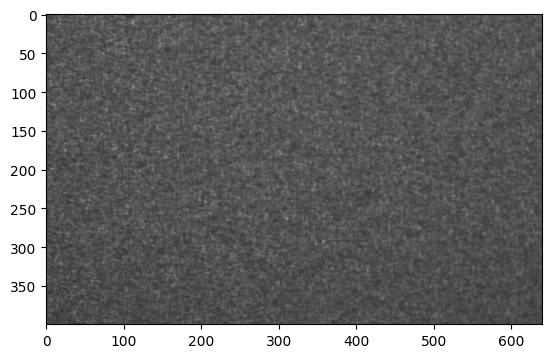

In [22]:
'''
Prediction from loaded model on memory
'''
import matplotlib.pyplot as plt

def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    model.eval()
    with torch.no_grad():
        yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

img, label = dataset[100]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Predicted:', predict_image(img, model))

In [20]:
import matplotlib.pyplot as plt
test_images, test_labels = next(iter(train_dataloader))
import numpy as np

fig = plt.figure(figsize=(15,3))
for i, img, label in zip(range(BATCH_SIZE), test_images, test_labels):
    numpy_img = np.transpose(img.detach().numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, BATCH_SIZE, i+1)
    ax.imshow(numpy_img)
    title = "Reconstructed Image"
    ax.set_title(title, fontsize=20)
plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

<Figure size 1500x300 with 0 Axes>

In [ ]:
'''
Training Phase
'''
import torch.optim as optim
from torch.autograd import Variable

def train(data_loader, size, model, criterion, optimizer, num_epochs=20):
	print('Start training')
	for epoch in range(num_epochs):
		print('Epoch {}/{}'.format(epoch, num_epochs-1))
		tloss = 0.0
		for data in data_loader:
			inputs, _ = data
			optimizer.zero_grad()
			encoding, logits = model(Variable(inputs.cuda()))
			loss = criterion(logits, Variable(inputs.cuda()))
			loss.backward()
			optimizer.step()
			tloss += loss.data[0]
		epoch_loss = tloss/size
		print('Epoch loss: {:4f}'.format(epoch_loss))
	print('Complete training')
	return model

# create model instance and upload into cuda device
model = ConvAutoencoder().cuda()

# 
criterion = nn.BCELoss()
size = len(dataset)

optimizer_fn = optim.Adam
optimizer = optimizer_fn(model.parameters(), lr=LEARNING_RATE)
model = train(dataloader, size, model, criterion, optimizer, num_epochs=EPOCH)

# test_image = random.choice(test_data)
# test_image = Variable(test_image[0].unsqueeze(0).cuda())
# _, out = model(test_image)

torchvision.utils.save_image(test_image.data, 'in.png')
torchvision.utils.save_image(out.data, 'out.png')

In [ ]:

# set dataloader
DATA_BATCH_SIZE = 10

dataset = ImageFolder(TRAIN_DATASET_PATH, transform=transforms.ToTensor())
dataloader = DataLoader(dataset=dataset, batch_size=DATA_BATCH_SIZE)


# calc mean and std for image normalization
_sum_channels = 0
_squared_sum_channels = 0
_total_batches = 0

for data, _ in tqdm(dataloader):
    _sum_channels += torch.mean(data, dim=[0,2,3]) # calc mean for each channels (dim=Batch, Channel, Height, Width)
    _squared_sum_channels += torch.mean(data**2, dim=[0,2,3])
    _total_batches += 1

mean = _sum_channels / _total_batches
std = (_squared_sum_channels / _squared_sum_channels - mean ** 2) ** 0.5
print(_sum_channels, _squared_sum_channels, _total_batches)
print(f"Mean : {mean}, Std:{std}")


# normalization(0~1) of dataset images
# normalization이 필요할까 모르겠다
stats = (tuple(mean.tolist()), tuple(std.tolist()))
train_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(*stats, inplace=True)])

train_dataset = ImageFolder(TRAIN_DATASET_PATH.as_posix(), train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=DATA_BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)